# Finetuning a BERT model for document classification based on MonoBERT

### Packages installieren

In [1]:
# Nur in der Colab-Umgebung ausführen

#!pip install -q -U "tensorflow-text==2.8.*"
#!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 3.9 MB/s 
     |████████████████████████████████| 462 kB 48.8 MB/s 
     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 1.2 MB 43.7 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 99 kB 4.0 MB/s 
     |████████████████████████████████| 1.1 MB 32.0 MB/s 
     |████████████████████████████████| 90 kB 3.9 MB/s 
     |████████████████████████████████| 596 kB 37.0 MB/s 
     |████████████████████████████████| 47.8 MB 10.7 MB/s 
     |████████████████████████████████| 352 kB 34.9 MB/s 
     |████████████████████████████████| 237 kB 34.5 MB/s 


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

import tensorflow_hub as hub

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

c:\users\pascal quindeau\appdata\local\programs\python\python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Prepare the data

Load documents.

In [7]:
docs_df = pd.read_csv("../corpus/dev.docs", delimiter="\t", header=None, names=["docid", "text"])

Load the queries "xyz.titles.queries" and the groundtruth "xyz.2-1-0.qrel".

In [4]:
queries_df = pd.read_csv("../query/dev.titles.queries", delimiter="\t", header=None, names=["queryid", "text"])
relqueries_df = pd.read_csv("../qrel/dev.2-1-0.qrel", delimiter="\t", header=None, names=["queryid", "0", "docid", "rellvl"])

relqueries_df.loc[:, "rellvl"] = 1

In [5]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

In [8]:
merged_data = relqueries_df.merge(docs_df, on="docid").merge(queries_df, on="queryid", suffixes=["doc", "query"])
merged_data = merged_data[["textquery", "textdoc", "rellvl"]]
merged_data

,textquery,textdoc,rellvl
0,why deep fried foods may cause cancer,birth weight head circumference prenatal expos...,1
1,why deep fried foods may cause cancer,statistical regression model estimation acryla...,1
2,why deep fried foods may cause cancer,chronic intake potato chips humans increases p...,1
3,why deep fried foods may cause cancer,dietary patterns breast cancer risk women pubm...,1
4,why deep fried foods may cause cancer,empirically derived dietary patterns risk post...,1
...,...,...,...
11380,is kimchi good for you ?,bacterial vaginosis variation dietary indices ...,1
11381,is kimchi good for you ?,high fat intake leads acute postprandial expos...,1
11382,is kimchi good for you ?,capacity foodstuffs induce innate immune activ...,1
11383,is kimchi good for you ?,acute subacute toxicity tyramine spermidine sp...,1


Create negative query examples.  
For each relevant document d given a query q return either  
a fixed number of negative examples per q or a negative exmpale
for each relevant document. 

In [37]:
def negSample(df, query_df, rel_df, n=None):
    #q = "why deep fried foods may cause cancer"
    neg_df = pd.DataFrame(columns=["textquery", "textdoc", "rellvl"])
    for i, q in enumerate(query_df["text"]):
        if n:
            size = n
        else:
            size = df[df["textquery"]==q].shape[0]
        tmp = df[~ (df["textquery"] == q)]["textdoc"]
        neg_samples = np.random.choice(tmp, size=size, replace=False)
        #print(i)
        df_tmp = pd.DataFrame(data={"textquery": q,
                           "textdoc": neg_samples,
                           "rellvl":0})
        neg_df = neg_df.append(df_tmp).copy()
    
    return neg_df.reset_index(drop=True)

In [40]:
negdf = negSample(merged_data, queries_df, relqueries_df, n=None)

In [14]:
train_data = merged_data.append(negdf)
train_data = train_data.sample(frac=1) # shuffle data
train_data

,textquery,textdoc,rellvl
5105,"protein , puberty , and pollutants",higher levels igf-i adrenal androgens age num ...,1
2104,vitamin e,calcified neurocysticercosis patients primary ...,0
2918,protein and heart disease,one-month strawberry-rich anthocyanin suppleme...,0
8650,treating multiple sclerosis with the swank ms ...,diet lifestyle etiology coronary artery diseas...,1
7665,cooked beans or sprouted beans ?,meal effects pulses blood glucose appetite foo...,1
...,...,...,...
9743,alzheimer ’ s disease : grain brain or meathead ?,reversing heart disease millennium--the flemin...,1
9879,veggie burgers,weight gain num years num meat-eating fish-eat...,1
53,detoxification,archaeologic dig rice-fruit diet reverses ecg ...,0
3965,can hibiscus tea cause coughing ?,prospective study long-term intake dietary fib...,0


## Load and build the model

### Preprocessing with Tokenizing

In [15]:
preprocessor = hub.load(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")


text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string, name="query"),
               tf.keras.layers.Input(shape=(), dtype=tf.string, name="document")]

tokenize = hub.KerasLayer(preprocessor.tokenize, name='tokenize')
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

# Step 2 (optional): modify tokenized inputs.
pass

# Step 3: pack input sequences for the Transformer encoder.
seq_length = 512  # Your choice here.
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length), name='preprocessing')  # Optional argument.

encoder_inputs = bert_pack_inputs(tokenized_inputs)


#input = preprocessor([["This is an amazing movie!"], ["Guten Tag!"]])

### The encoder

In [16]:
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2",
    trainable=True,  name='BERT_encoder')

In [17]:
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]

### Plot input length

In [63]:
res_tokenize = [tokenize([tf.constant(i), tf.constant(j)]) for (i, j) in zip(train_data["textquery"], train_data["textdoc"])]

In [55]:
tmp = [i.numpy() for i in res_tokenize]

In [88]:
train_data["textquery"]

5105                   protein , puberty , and pollutants
2104                                            vitamin e
2918                            protein and heart disease
8650    treating multiple sclerosis with the swank ms ...
7665                     cooked beans or sprouted beans ?
                              ...                        
9743    alzheimer ’ s disease : grain brain or meathead ?
9879                                       veggie burgers
53                                         detoxification
3965                    can hibiscus tea cause coughing ?
4647                                                 cats
Name: textquery, Length: 16260, dtype: object

In [97]:
res = []

for sample in tmp:
  item_l = []
  for item in sample:
    for number in item:
      for val in number.tolist():
        item_l.append(val)
  res.append(item_l)

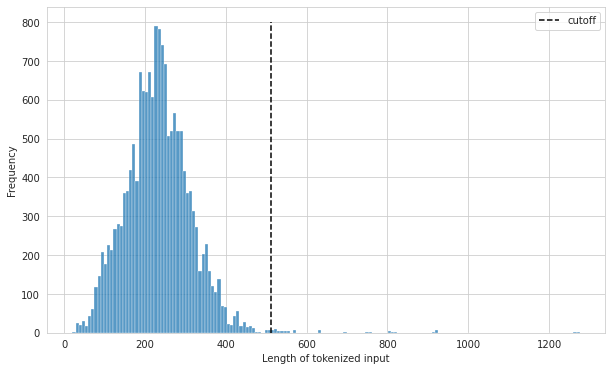

In [109]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.histplot([len(i)+3 for i in res])
plt.vlines(x=512, ymin=0, ymax=800, linestyles="--", label="cutoff")
plt.xlabel("Length of tokenized input")
plt.ylabel("Frequency")
plt.legend()

In [110]:
x = tf.keras.layers.Dropout(0.1)(pooled_output)
x = tf.keras.layers.Dense(1, activation=None, name='classifier')(x)
model = tf.keras.Model(text_inputs, x)

In [111]:
#print(model([sentences1, sentences2]))

In [112]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(train_data)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()


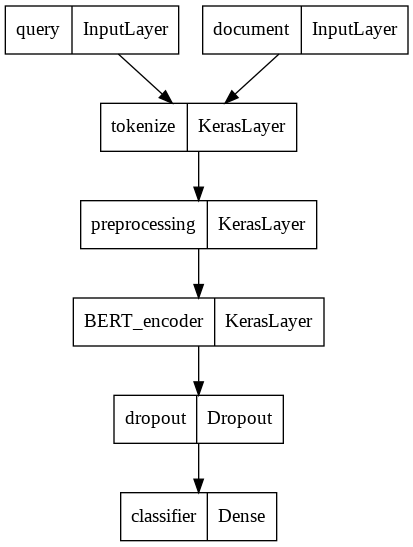

In [113]:
tf.keras.utils.plot_model(model)

In [114]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

In [115]:
print(f'Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2')
history = model.fit(x=[train_data["textquery"], train_data["textdoc"]], 
                    y=train_data["rellvl"].astype("int64"),
                    validation_split=0.1,
                    epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2
Epoch 1/3
458/458 [==============================] - 767s 2s/step - loss: 0.5269 - binary_accuracy: 0.7038 - val_loss: 0.4693 - val_binary_accuracy: 0.7183
Epoch 2/3
458/458 [==============================] - 753s 2s/step - loss: 0.4523 - binary_accuracy: 0.7694 - val_loss: 0.4412 - val_binary_accuracy: 0.7823
Epoch 3/3
458/458 [==============================] - 752s 2s/step - loss: 0.4178 - binary_accuracy: 0.7926 - val_loss: 0.4331 - val_binary_accuracy: 0.7601


## Store the model for later use

In [116]:
dataset_name = 'mono'
saved_model_path = '/content/drive/MyDrive/monobert/{}_bert'.format(dataset_name.replace('/', '_'))

model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/monobert/mono_bert/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/monobert/mono_bert/assets
